In [ ]:
import zipfile
import os


zip_path = '/content/drive/MyDrive/violence_detection_resnet/Violence Detection.v2i.folder.zip'

# Destination directory to extract to
extract_to = '/content/drive/MyDrive/violence_detection_resnet'

# Create the directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Extraction complete!")


✅ Extraction complete!


In [ ]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os


In [ ]:
train_dir = '/content/drive/MyDrive/violence_detection_resnet/train'
val_dir = '/content/drive/MyDrive/violence_detection_resnet/valid'
test_dir ='/content/drive/MyDrive/violence_detection_resnet/test'

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])


In [ ]:
from torch.utils.data import Subset
import random

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
subset_size = int(0.2 * len(train_dataset))  # use 20%
subset_indices = random.sample(range(len(train_dataset)), subset_size)
train_subset = Subset(train_dataset, subset_indices)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True , num_workers=2, pin_memory=True)

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False ,num_workers=2, pin_memory=True)

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=2, pin_memory=True)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 25.2 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import optuna
import time


def objective(trial):
    start_time = time.time()

    # 🔧 Hyperparameters
    fc_units = trial.suggest_int("fc_units", 128, 512)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    lr = trial.suggest_float("lr", 1e-3, 0.1, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam"])

    print(f"\n🧪 Starting Trial {trial.number}")
    print(f"🔧 Params: fc_units={fc_units}, dropout={dropout_rate:.2f}, lr={lr:.5f}, optimizer={optimizer_name}")

    # 🧠 Load ResNet34
    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    for name, param in model.named_parameters():
        if "fc" not in name:
            param.requires_grad = False

    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, fc_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(fc_units, 1)  # Binary classification
    )
    model.to(device)

    # ⚙️ Optimizer
    optimizer_class = {
        "Adam": torch.optim.Adam,
        "SGD": torch.optim.SGD,
        "RMSprop": torch.optim.RMSprop
    }[optimizer_name]
    optimizer = optimizer_class(model.fc.parameters(), lr=lr)

    # 🎯 Loss Function
    criterion = nn.BCEWithLogitsLoss()

    # 🏋️ Training
    model.train()
    for epoch in range(2):  # Keep small for tuning
        epoch_loss = 0
        print(f"🔄 Epoch {epoch+1}")
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"  🔁 Batch {batch_idx}/{len(train_loader)} — Loss: {loss.item():.4f}")
        print(f"📉 Epoch {epoch+1} Loss: {epoch_loss:.4f}")

    # 🧪 Validation
    model.eval()
    correct = 0
    total = 0
    print("🔍 Starting Validation...")
    with torch.no_grad():
        for idx, (images, labels) in enumerate(val_loader):
            try:
                images = images.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                preds = torch.sigmoid(outputs) > 0.5
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                if idx % 10 == 0:
                    print(f"  ✅ Val Batch {idx}/{len(val_loader)}")

            except Exception as e:
                print(f"❌ Error in val batch {idx}: {e}")
                continue

    acc = correct / total if total > 0 else 0.0
    print(f"✅ Trial {trial.number} Accuracy: {acc:.4f} — Time: {time.time() - start_time:.2f}s")

    return acc


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)


[I 2025-07-05 17:32:52,664] A new study created in memory with name: no-name-cf260e84-cff5-462f-87bb-1e4b9d6c6a19



🧪 Starting Trial 0
🔧 Params: fc_units=176, dropout=0.33, lr=0.00966, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.6615
  🔁 Batch 10/141 — Loss: 0.6583
  🔁 Batch 20/141 — Loss: 0.5959
  🔁 Batch 30/141 — Loss: 0.6083
  🔁 Batch 40/141 — Loss: 0.6605
  🔁 Batch 50/141 — Loss: 0.5183
  🔁 Batch 60/141 — Loss: 0.4496
  🔁 Batch 70/141 — Loss: 0.5833
  🔁 Batch 80/141 — Loss: 0.6915
  🔁 Batch 90/141 — Loss: 0.5206
  🔁 Batch 100/141 — Loss: 0.5426
  🔁 Batch 110/141 — Loss: 0.5495
  🔁 Batch 120/141 — Loss: 0.4569
  🔁 Batch 130/141 — Loss: 0.5785
  🔁 Batch 140/141 — Loss: 0.5301
📉 Epoch 1 Loss: 86.9455
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.4739
  🔁 Batch 10/141 — Loss: 0.5528
  🔁 Batch 20/141 — Loss: 0.5750
  🔁 Batch 30/141 — Loss: 0.5480
  🔁 Batch 40/141 — Loss: 0.6001
  🔁 Batch 50/141 — Loss: 0.7789
  🔁 Batch 60/141 — Loss: 0.5255
  🔁 Batch 70/141 — Loss: 0.5622
  🔁 Batch 80/141 — Loss: 0.4778
  🔁 Batch 90/141 — Loss: 0.5730
  🔁 Batch 100/141 — Loss: 0.6214
  🔁 Batch 110/141 — Loss: 0.4181
  

[I 2025-07-05 17:35:17,324] Trial 0 finished with value: 0.7215727948990436 and parameters: {'fc_units': 176, 'dropout_rate': 0.32752723013049595, 'lr': 0.009655506872834469, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.7215727948990436.


✅ Trial 0 Accuracy: 0.7216 — Time: 144.66s

🧪 Starting Trial 1
🔧 Params: fc_units=384, dropout=0.31, lr=0.02229, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.7459
  🔁 Batch 10/141 — Loss: 2.4720
  🔁 Batch 20/141 — Loss: 0.6606
  🔁 Batch 30/141 — Loss: 0.6507
  🔁 Batch 40/141 — Loss: 0.5665
  🔁 Batch 50/141 — Loss: 0.6076
  🔁 Batch 60/141 — Loss: 0.6029
  🔁 Batch 70/141 — Loss: 0.5875
  🔁 Batch 80/141 — Loss: 0.8757
  🔁 Batch 90/141 — Loss: 0.6380
  🔁 Batch 100/141 — Loss: 0.5720
  🔁 Batch 110/141 — Loss: 0.6275
  🔁 Batch 120/141 — Loss: 0.5995
  🔁 Batch 130/141 — Loss: 0.5706
  🔁 Batch 140/141 — Loss: 0.4976
📉 Epoch 1 Loss: 134.1214
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.6054
  🔁 Batch 10/141 — Loss: 0.6747
  🔁 Batch 20/141 — Loss: 0.5676
  🔁 Batch 30/141 — Loss: 0.6665
  🔁 Batch 40/141 — Loss: 0.5850
  🔁 Batch 50/141 — Loss: 0.5590
  🔁 Batch 60/141 — Loss: 0.5328
  🔁 Batch 70/141 — Loss: 0.7082
  🔁 Batch 80/141 — Loss: 0.5223
  🔁 Batch 90/141 — Loss: 0.5781
  🔁 Batch 100/141 — Loss

[I 2025-07-05 17:36:01,474] Trial 1 finished with value: 0.71413390010627 and parameters: {'fc_units': 384, 'dropout_rate': 0.31186132737932787, 'lr': 0.02228539417800051, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.7215727948990436.


✅ Trial 1 Accuracy: 0.7141 — Time: 44.15s

🧪 Starting Trial 2
🔧 Params: fc_units=216, dropout=0.32, lr=0.00336, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.7242
  🔁 Batch 10/141 — Loss: 0.6848
  🔁 Batch 20/141 — Loss: 0.6266
  🔁 Batch 30/141 — Loss: 0.6979
  🔁 Batch 40/141 — Loss: 0.6233
  🔁 Batch 50/141 — Loss: 0.4922
  🔁 Batch 60/141 — Loss: 0.6562
  🔁 Batch 70/141 — Loss: 0.7026
  🔁 Batch 80/141 — Loss: 0.4980
  🔁 Batch 90/141 — Loss: 0.6026
  🔁 Batch 100/141 — Loss: 0.4857
  🔁 Batch 110/141 — Loss: 0.5776
  🔁 Batch 120/141 — Loss: 0.6077
  🔁 Batch 130/141 — Loss: 0.5884
  🔁 Batch 140/141 — Loss: 0.6241
📉 Epoch 1 Loss: 85.3128
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.4992
  🔁 Batch 10/141 — Loss: 0.5948
  🔁 Batch 20/141 — Loss: 0.5335
  🔁 Batch 30/141 — Loss: 0.4872
  🔁 Batch 40/141 — Loss: 0.5429
  🔁 Batch 50/141 — Loss: 0.5512
  🔁 Batch 60/141 — Loss: 0.4654
  🔁 Batch 70/141 — Loss: 0.6192
  🔁 Batch 80/141 — Loss: 0.4421
  🔁 Batch 90/141 — Loss: 0.6149
  🔁 Batch 100/141 — Loss: 

[I 2025-07-05 17:36:43,805] Trial 2 finished with value: 0.6875664187035069 and parameters: {'fc_units': 216, 'dropout_rate': 0.31707322529172005, 'lr': 0.003357641534983082, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.7215727948990436.


✅ Trial 2 Accuracy: 0.6876 — Time: 42.33s

🧪 Starting Trial 3
🔧 Params: fc_units=223, dropout=0.46, lr=0.00179, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.7215
  🔁 Batch 10/141 — Loss: 0.6750
  🔁 Batch 20/141 — Loss: 0.6028
  🔁 Batch 30/141 — Loss: 0.5534
  🔁 Batch 40/141 — Loss: 0.6459
  🔁 Batch 50/141 — Loss: 0.5888
  🔁 Batch 60/141 — Loss: 0.5317
  🔁 Batch 70/141 — Loss: 0.5659
  🔁 Batch 80/141 — Loss: 0.4866
  🔁 Batch 90/141 — Loss: 0.6782
  🔁 Batch 100/141 — Loss: 0.5622
  🔁 Batch 110/141 — Loss: 0.5575
  🔁 Batch 120/141 — Loss: 0.5824
  🔁 Batch 130/141 — Loss: 0.6198
  🔁 Batch 140/141 — Loss: 0.5844
📉 Epoch 1 Loss: 84.2921
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.5042
  🔁 Batch 10/141 — Loss: 0.5438
  🔁 Batch 20/141 — Loss: 0.6356
  🔁 Batch 30/141 — Loss: 0.7589
  🔁 Batch 40/141 — Loss: 0.5816
  🔁 Batch 50/141 — Loss: 0.4727
  🔁 Batch 60/141 — Loss: 0.6801
  🔁 Batch 70/141 — Loss: 0.6444
  🔁 Batch 80/141 — Loss: 0.6021
  🔁 Batch 90/141 — Loss: 0.3261
  🔁 Batch 100/141 — Loss: 

[I 2025-07-05 17:37:26,222] Trial 3 finished with value: 0.7460148777895855 and parameters: {'fc_units': 223, 'dropout_rate': 0.4636708898155023, 'lr': 0.001792576262435725, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.7460148777895855.


✅ Trial 3 Accuracy: 0.7460 — Time: 42.41s

🧪 Starting Trial 4
🔧 Params: fc_units=493, dropout=0.34, lr=0.01596, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.6652
  🔁 Batch 10/141 — Loss: 1.2774
  🔁 Batch 20/141 — Loss: 0.7049
  🔁 Batch 30/141 — Loss: 0.6117
  🔁 Batch 40/141 — Loss: 0.6647
  🔁 Batch 50/141 — Loss: 0.6331
  🔁 Batch 60/141 — Loss: 0.6467
  🔁 Batch 70/141 — Loss: 0.5489
  🔁 Batch 80/141 — Loss: 0.5503
  🔁 Batch 90/141 — Loss: 0.6206
  🔁 Batch 100/141 — Loss: 0.6255
  🔁 Batch 110/141 — Loss: 0.6715
  🔁 Batch 120/141 — Loss: 0.5314
  🔁 Batch 130/141 — Loss: 0.6247
  🔁 Batch 140/141 — Loss: 0.5094
📉 Epoch 1 Loss: 132.2618
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.4873
  🔁 Batch 10/141 — Loss: 0.5582
  🔁 Batch 20/141 — Loss: 0.5929
  🔁 Batch 30/141 — Loss: 0.6328
  🔁 Batch 40/141 — Loss: 0.5090
  🔁 Batch 50/141 — Loss: 0.5835
  🔁 Batch 60/141 — Loss: 0.7221
  🔁 Batch 70/141 — Loss: 0.6091
  🔁 Batch 80/141 — Loss: 0.6577
  🔁 Batch 90/141 — Loss: 0.5996
  🔁 Batch 100/141 — Loss:

[I 2025-07-05 17:38:09,605] Trial 4 finished with value: 0.7162592986184909 and parameters: {'fc_units': 493, 'dropout_rate': 0.34480496686464945, 'lr': 0.015964667408320053, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.7460148777895855.


✅ Trial 4 Accuracy: 0.7163 — Time: 43.38s

🧪 Starting Trial 5
🔧 Params: fc_units=249, dropout=0.47, lr=0.04429, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.7330
  🔁 Batch 10/141 — Loss: 5.7516
  🔁 Batch 20/141 — Loss: 0.7091
  🔁 Batch 30/141 — Loss: 0.6881
  🔁 Batch 40/141 — Loss: 0.6894
  🔁 Batch 50/141 — Loss: 0.6967
  🔁 Batch 60/141 — Loss: 0.6331
  🔁 Batch 70/141 — Loss: 0.5546
  🔁 Batch 80/141 — Loss: 0.8096
  🔁 Batch 90/141 — Loss: 0.6122
  🔁 Batch 100/141 — Loss: 0.6896
  🔁 Batch 110/141 — Loss: 0.6923
  🔁 Batch 120/141 — Loss: 0.6443
  🔁 Batch 130/141 — Loss: 0.7256
  🔁 Batch 140/141 — Loss: 0.6924
📉 Epoch 1 Loss: 244.9136
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.6887
  🔁 Batch 10/141 — Loss: 0.6952
  🔁 Batch 20/141 — Loss: 0.6959
  🔁 Batch 30/141 — Loss: 0.7120
  🔁 Batch 40/141 — Loss: 0.6916
  🔁 Batch 50/141 — Loss: 0.6856
  🔁 Batch 60/141 — Loss: 0.7022
  🔁 Batch 70/141 — Loss: 0.7253
  🔁 Batch 80/141 — Loss: 0.6763
  🔁 Batch 90/141 — Loss: 0.6884
  🔁 Batch 100/141 — Loss:

[I 2025-07-05 17:38:54,072] Trial 5 finished with value: 0.5313496280552603 and parameters: {'fc_units': 249, 'dropout_rate': 0.47204098932318533, 'lr': 0.04429247156414002, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.7460148777895855.


✅ Trial 5 Accuracy: 0.5313 — Time: 44.46s

🧪 Starting Trial 6
🔧 Params: fc_units=448, dropout=0.23, lr=0.00159, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.6847
  🔁 Batch 10/141 — Loss: 0.5392
  🔁 Batch 20/141 — Loss: 0.7341
  🔁 Batch 30/141 — Loss: 0.6113
  🔁 Batch 40/141 — Loss: 0.4892
  🔁 Batch 50/141 — Loss: 0.4984
  🔁 Batch 60/141 — Loss: 0.4293
  🔁 Batch 70/141 — Loss: 0.6531
  🔁 Batch 80/141 — Loss: 0.5980
  🔁 Batch 90/141 — Loss: 0.5960
  🔁 Batch 100/141 — Loss: 0.5636
  🔁 Batch 110/141 — Loss: 0.6349
  🔁 Batch 120/141 — Loss: 0.4781
  🔁 Batch 130/141 — Loss: 0.4397
  🔁 Batch 140/141 — Loss: 0.4598
📉 Epoch 1 Loss: 82.5652
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.3493
  🔁 Batch 10/141 — Loss: 0.7938
  🔁 Batch 20/141 — Loss: 0.5203
  🔁 Batch 30/141 — Loss: 0.3954
  🔁 Batch 40/141 — Loss: 0.5610
  🔁 Batch 50/141 — Loss: 0.4877
  🔁 Batch 60/141 — Loss: 0.5412
  🔁 Batch 70/141 — Loss: 0.6850
  🔁 Batch 80/141 — Loss: 0.4449
  🔁 Batch 90/141 — Loss: 0.4802
  🔁 Batch 100/141 — Loss: 

[I 2025-07-05 17:39:36,665] Trial 6 finished with value: 0.7608926673751328 and parameters: {'fc_units': 448, 'dropout_rate': 0.23459621052390184, 'lr': 0.0015898750986332868, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7608926673751328.


✅ Trial 6 Accuracy: 0.7609 — Time: 42.59s

🧪 Starting Trial 7
🔧 Params: fc_units=167, dropout=0.39, lr=0.00782, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.6880
  🔁 Batch 10/141 — Loss: 0.9461
  🔁 Batch 20/141 — Loss: 0.6964
  🔁 Batch 30/141 — Loss: 0.6761
  🔁 Batch 40/141 — Loss: 0.7135
  🔁 Batch 50/141 — Loss: 0.6527
  🔁 Batch 60/141 — Loss: 0.5819
  🔁 Batch 70/141 — Loss: 0.5532
  🔁 Batch 80/141 — Loss: 0.5594
  🔁 Batch 90/141 — Loss: 0.5167
  🔁 Batch 100/141 — Loss: 0.6005
  🔁 Batch 110/141 — Loss: 0.7382
  🔁 Batch 120/141 — Loss: 0.5253
  🔁 Batch 130/141 — Loss: 0.5798
  🔁 Batch 140/141 — Loss: 0.5561
📉 Epoch 1 Loss: 95.4782
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.5347
  🔁 Batch 10/141 — Loss: 0.5668
  🔁 Batch 20/141 — Loss: 0.6736
  🔁 Batch 30/141 — Loss: 0.5182
  🔁 Batch 40/141 — Loss: 0.5737
  🔁 Batch 50/141 — Loss: 0.6129
  🔁 Batch 60/141 — Loss: 0.4947
  🔁 Batch 70/141 — Loss: 0.5843
  🔁 Batch 80/141 — Loss: 0.6121
  🔁 Batch 90/141 — Loss: 0.4958
  🔁 Batch 100/141 — Loss: 

[I 2025-07-05 17:40:19,147] Trial 7 finished with value: 0.7438894792773645 and parameters: {'fc_units': 167, 'dropout_rate': 0.387434397007895, 'lr': 0.007822729667233424, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7608926673751328.


✅ Trial 7 Accuracy: 0.7439 — Time: 42.48s

🧪 Starting Trial 8
🔧 Params: fc_units=154, dropout=0.29, lr=0.02679, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.6976
  🔁 Batch 10/141 — Loss: 0.9112
  🔁 Batch 20/141 — Loss: 0.6715
  🔁 Batch 30/141 — Loss: 0.6577
  🔁 Batch 40/141 — Loss: 0.6690
  🔁 Batch 50/141 — Loss: 0.6234
  🔁 Batch 60/141 — Loss: 0.6679
  🔁 Batch 70/141 — Loss: 0.6196
  🔁 Batch 80/141 — Loss: 0.7474
  🔁 Batch 90/141 — Loss: 0.5959
  🔁 Batch 100/141 — Loss: 0.6356
  🔁 Batch 110/141 — Loss: 0.5184
  🔁 Batch 120/141 — Loss: 0.6834
  🔁 Batch 130/141 — Loss: 0.6486
  🔁 Batch 140/141 — Loss: 0.5866
📉 Epoch 1 Loss: 118.2351
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.6218
  🔁 Batch 10/141 — Loss: 0.6159
  🔁 Batch 20/141 — Loss: 0.5676
  🔁 Batch 30/141 — Loss: 0.7055
  🔁 Batch 40/141 — Loss: 0.8213
  🔁 Batch 50/141 — Loss: 0.6609
  🔁 Batch 60/141 — Loss: 0.7575
  🔁 Batch 70/141 — Loss: 0.5883
  🔁 Batch 80/141 — Loss: 0.4433
  🔁 Batch 90/141 — Loss: 0.6195
  🔁 Batch 100/141 — Loss:

[I 2025-07-05 17:41:03,043] Trial 8 finished with value: 0.7417640807651434 and parameters: {'fc_units': 154, 'dropout_rate': 0.2890790353056877, 'lr': 0.026789543819394336, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7608926673751328.


✅ Trial 8 Accuracy: 0.7418 — Time: 43.89s

🧪 Starting Trial 9
🔧 Params: fc_units=465, dropout=0.49, lr=0.00497, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.6709
  🔁 Batch 10/141 — Loss: 0.8960
  🔁 Batch 20/141 — Loss: 0.6090
  🔁 Batch 30/141 — Loss: 0.6385
  🔁 Batch 40/141 — Loss: 0.5381
  🔁 Batch 50/141 — Loss: 0.6352
  🔁 Batch 60/141 — Loss: 0.6441
  🔁 Batch 70/141 — Loss: 0.6095
  🔁 Batch 80/141 — Loss: 0.5471
  🔁 Batch 90/141 — Loss: 0.4717
  🔁 Batch 100/141 — Loss: 0.6913
  🔁 Batch 110/141 — Loss: 0.5181
  🔁 Batch 120/141 — Loss: 0.6533
  🔁 Batch 130/141 — Loss: 0.6323
  🔁 Batch 140/141 — Loss: 0.5255
📉 Epoch 1 Loss: 91.1316
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.5448
  🔁 Batch 10/141 — Loss: 0.4925
  🔁 Batch 20/141 — Loss: 0.6299
  🔁 Batch 30/141 — Loss: 0.4437
  🔁 Batch 40/141 — Loss: 0.6176
  🔁 Batch 50/141 — Loss: 0.6837
  🔁 Batch 60/141 — Loss: 0.6522
  🔁 Batch 70/141 — Loss: 0.5821
  🔁 Batch 80/141 — Loss: 0.9936
  🔁 Batch 90/141 — Loss: 0.7312
  🔁 Batch 100/141 — Loss: 

[I 2025-07-05 17:41:45,784] Trial 9 finished with value: 0.5844845908607864 and parameters: {'fc_units': 465, 'dropout_rate': 0.4929087741557362, 'lr': 0.004972596435006716, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7608926673751328.


✅ Trial 9 Accuracy: 0.5845 — Time: 42.74s

🧪 Starting Trial 10
🔧 Params: fc_units=354, dropout=0.21, lr=0.00108, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.6841
  🔁 Batch 10/141 — Loss: 0.6414
  🔁 Batch 20/141 — Loss: 0.5072
  🔁 Batch 30/141 — Loss: 0.6696
  🔁 Batch 40/141 — Loss: 0.6686
  🔁 Batch 50/141 — Loss: 0.6099
  🔁 Batch 60/141 — Loss: 0.6159
  🔁 Batch 70/141 — Loss: 0.6102
  🔁 Batch 80/141 — Loss: 0.7449
  🔁 Batch 90/141 — Loss: 0.5215
  🔁 Batch 100/141 — Loss: 0.5149
  🔁 Batch 110/141 — Loss: 0.6323
  🔁 Batch 120/141 — Loss: 0.5314
  🔁 Batch 130/141 — Loss: 0.6624
  🔁 Batch 140/141 — Loss: 0.7346
📉 Epoch 1 Loss: 82.4436
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.5753
  🔁 Batch 10/141 — Loss: 0.5132
  🔁 Batch 20/141 — Loss: 0.4189
  🔁 Batch 30/141 — Loss: 0.6022
  🔁 Batch 40/141 — Loss: 0.3944
  🔁 Batch 50/141 — Loss: 0.4706
  🔁 Batch 60/141 — Loss: 0.5284
  🔁 Batch 70/141 — Loss: 0.4317
  🔁 Batch 80/141 — Loss: 0.5145
  🔁 Batch 90/141 — Loss: 0.4201
  🔁 Batch 100/141 — Loss:

[I 2025-07-05 17:42:28,766] Trial 10 finished with value: 0.7311370882040382 and parameters: {'fc_units': 354, 'dropout_rate': 0.21082040011982908, 'lr': 0.0010840711630739814, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7608926673751328.


✅ Trial 10 Accuracy: 0.7311 — Time: 42.98s

🧪 Starting Trial 11
🔧 Params: fc_units=277, dropout=0.41, lr=0.00119, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.7500
  🔁 Batch 10/141 — Loss: 0.6743
  🔁 Batch 20/141 — Loss: 0.5361
  🔁 Batch 30/141 — Loss: 0.5781
  🔁 Batch 40/141 — Loss: 0.6133
  🔁 Batch 50/141 — Loss: 0.5436
  🔁 Batch 60/141 — Loss: 0.6914
  🔁 Batch 70/141 — Loss: 0.5831
  🔁 Batch 80/141 — Loss: 0.5008
  🔁 Batch 90/141 — Loss: 0.5027
  🔁 Batch 100/141 — Loss: 0.5839
  🔁 Batch 110/141 — Loss: 0.6798
  🔁 Batch 120/141 — Loss: 0.4419
  🔁 Batch 130/141 — Loss: 0.5180
  🔁 Batch 140/141 — Loss: 0.5975
📉 Epoch 1 Loss: 83.7143
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.6343
  🔁 Batch 10/141 — Loss: 0.5551
  🔁 Batch 20/141 — Loss: 0.4857
  🔁 Batch 30/141 — Loss: 0.4849
  🔁 Batch 40/141 — Loss: 0.6452
  🔁 Batch 50/141 — Loss: 0.4695
  🔁 Batch 60/141 — Loss: 0.4955
  🔁 Batch 70/141 — Loss: 0.4584
  🔁 Batch 80/141 — Loss: 0.4318
  🔁 Batch 90/141 — Loss: 0.5224
  🔁 Batch 100/141 — Loss

[I 2025-07-05 17:43:11,513] Trial 11 finished with value: 0.7545164718384697 and parameters: {'fc_units': 277, 'dropout_rate': 0.41247558203185347, 'lr': 0.0011911064270425616, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7608926673751328.


✅ Trial 11 Accuracy: 0.7545 — Time: 42.74s

🧪 Starting Trial 12
🔧 Params: fc_units=299, dropout=0.41, lr=0.00106, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.7063
  🔁 Batch 10/141 — Loss: 0.5648
  🔁 Batch 20/141 — Loss: 0.5671
  🔁 Batch 30/141 — Loss: 0.7539
  🔁 Batch 40/141 — Loss: 0.6312
  🔁 Batch 50/141 — Loss: 0.4643
  🔁 Batch 60/141 — Loss: 0.5586
  🔁 Batch 70/141 — Loss: 0.3896
  🔁 Batch 80/141 — Loss: 0.5316
  🔁 Batch 90/141 — Loss: 0.6737
  🔁 Batch 100/141 — Loss: 0.5964
  🔁 Batch 110/141 — Loss: 0.5261
  🔁 Batch 120/141 — Loss: 0.6636
  🔁 Batch 130/141 — Loss: 0.6832
  🔁 Batch 140/141 — Loss: 0.6446
📉 Epoch 1 Loss: 84.0668
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.5076
  🔁 Batch 10/141 — Loss: 0.5441
  🔁 Batch 20/141 — Loss: 0.5461
  🔁 Batch 30/141 — Loss: 0.7014
  🔁 Batch 40/141 — Loss: 0.5255
  🔁 Batch 50/141 — Loss: 0.6022
  🔁 Batch 60/141 — Loss: 0.5745
  🔁 Batch 70/141 — Loss: 0.5266
  🔁 Batch 80/141 — Loss: 0.4628
  🔁 Batch 90/141 — Loss: 0.5527
  🔁 Batch 100/141 — Loss

[I 2025-07-05 17:43:56,996] Trial 12 finished with value: 0.7109458023379384 and parameters: {'fc_units': 299, 'dropout_rate': 0.4118401117649595, 'lr': 0.0010599837141027806, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7608926673751328.


✅ Trial 12 Accuracy: 0.7109 — Time: 45.48s

🧪 Starting Trial 13
🔧 Params: fc_units=416, dropout=0.20, lr=0.00255, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.7555
  🔁 Batch 10/141 — Loss: 0.9050
  🔁 Batch 20/141 — Loss: 0.6969
  🔁 Batch 30/141 — Loss: 0.6353
  🔁 Batch 40/141 — Loss: 0.6188
  🔁 Batch 50/141 — Loss: 0.5445
  🔁 Batch 60/141 — Loss: 0.5842
  🔁 Batch 70/141 — Loss: 0.6537
  🔁 Batch 80/141 — Loss: 0.6096
  🔁 Batch 90/141 — Loss: 0.6863
  🔁 Batch 100/141 — Loss: 0.5971
  🔁 Batch 110/141 — Loss: 0.6056
  🔁 Batch 120/141 — Loss: 0.6795
  🔁 Batch 130/141 — Loss: 0.5595
  🔁 Batch 140/141 — Loss: 0.6442
📉 Epoch 1 Loss: 87.8474
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.5773
  🔁 Batch 10/141 — Loss: 0.5173
  🔁 Batch 20/141 — Loss: 0.4249
  🔁 Batch 30/141 — Loss: 0.6732
  🔁 Batch 40/141 — Loss: 0.5755
  🔁 Batch 50/141 — Loss: 0.4949
  🔁 Batch 60/141 — Loss: 0.3702
  🔁 Batch 70/141 — Loss: 0.5095
  🔁 Batch 80/141 — Loss: 0.4687
  🔁 Batch 90/141 — Loss: 0.7104
  🔁 Batch 100/141 — Loss

[I 2025-07-05 17:44:39,676] Trial 13 finished with value: 0.7608926673751328 and parameters: {'fc_units': 416, 'dropout_rate': 0.20178329263631672, 'lr': 0.0025510023651235643, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7608926673751328.


✅ Trial 13 Accuracy: 0.7609 — Time: 42.68s

🧪 Starting Trial 14
🔧 Params: fc_units=426, dropout=0.22, lr=0.00311, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.6987
  🔁 Batch 10/141 — Loss: 0.5648
  🔁 Batch 20/141 — Loss: 0.5895
  🔁 Batch 30/141 — Loss: 0.7406
  🔁 Batch 40/141 — Loss: 0.6728
  🔁 Batch 50/141 — Loss: 0.4980
  🔁 Batch 60/141 — Loss: 0.7409
  🔁 Batch 70/141 — Loss: 0.5308
  🔁 Batch 80/141 — Loss: 0.6278
  🔁 Batch 90/141 — Loss: 0.6305
  🔁 Batch 100/141 — Loss: 0.5070
  🔁 Batch 110/141 — Loss: 0.3844
  🔁 Batch 120/141 — Loss: 0.4790
  🔁 Batch 130/141 — Loss: 0.4792
  🔁 Batch 140/141 — Loss: 0.6830
📉 Epoch 1 Loss: 85.3290
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.5783
  🔁 Batch 10/141 — Loss: 0.5220
  🔁 Batch 20/141 — Loss: 0.4208
  🔁 Batch 30/141 — Loss: 0.6324
  🔁 Batch 40/141 — Loss: 0.5394
  🔁 Batch 50/141 — Loss: 0.4522
  🔁 Batch 60/141 — Loss: 0.5182
  🔁 Batch 70/141 — Loss: 0.4659
  🔁 Batch 80/141 — Loss: 0.4581
  🔁 Batch 90/141 — Loss: 0.3852
  🔁 Batch 100/141 — Loss

[I 2025-07-05 17:45:22,272] Trial 14 finished with value: 0.7566418703506907 and parameters: {'fc_units': 426, 'dropout_rate': 0.21943778466903147, 'lr': 0.003106345979844847, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7608926673751328.


✅ Trial 14 Accuracy: 0.7566 — Time: 42.59s

🧪 Starting Trial 15
🔧 Params: fc_units=419, dropout=0.26, lr=0.09542, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.7490
  🔁 Batch 10/141 — Loss: 20.4694
  🔁 Batch 20/141 — Loss: 0.6561
  🔁 Batch 30/141 — Loss: 0.6866
  🔁 Batch 40/141 — Loss: 0.6836
  🔁 Batch 50/141 — Loss: 0.6944
  🔁 Batch 60/141 — Loss: 1.4247
  🔁 Batch 70/141 — Loss: 0.6963
  🔁 Batch 80/141 — Loss: 0.7080
  🔁 Batch 90/141 — Loss: 0.6844
  🔁 Batch 100/141 — Loss: 0.6780
  🔁 Batch 110/141 — Loss: 0.6912
  🔁 Batch 120/141 — Loss: 0.6940
  🔁 Batch 130/141 — Loss: 0.6937
  🔁 Batch 140/141 — Loss: 0.7011
📉 Epoch 1 Loss: 1047.6059
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.7032
  🔁 Batch 10/141 — Loss: 0.6749
  🔁 Batch 20/141 — Loss: 0.6798
  🔁 Batch 30/141 — Loss: 0.6861
  🔁 Batch 40/141 — Loss: 0.6912
  🔁 Batch 50/141 — Loss: 0.6822
  🔁 Batch 60/141 — Loss: 0.7004
  🔁 Batch 70/141 — Loss: 0.7082
  🔁 Batch 80/141 — Loss: 0.6793
  🔁 Batch 90/141 — Loss: 0.6869
  🔁 Batch 100/141 — L

[I 2025-07-05 17:46:04,446] Trial 15 finished with value: 0.5313496280552603 and parameters: {'fc_units': 419, 'dropout_rate': 0.25971090207968056, 'lr': 0.09542082454767342, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7608926673751328.


✅ Trial 15 Accuracy: 0.5313 — Time: 42.17s

🧪 Starting Trial 16
🔧 Params: fc_units=507, dropout=0.23, lr=0.00200, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.6930
  🔁 Batch 10/141 — Loss: 0.6580
  🔁 Batch 20/141 — Loss: 0.5871
  🔁 Batch 30/141 — Loss: 0.6813
  🔁 Batch 40/141 — Loss: 0.5974
  🔁 Batch 50/141 — Loss: 0.7064
  🔁 Batch 60/141 — Loss: 0.5917
  🔁 Batch 70/141 — Loss: 0.6101
  🔁 Batch 80/141 — Loss: 0.6997
  🔁 Batch 90/141 — Loss: 0.5875
  🔁 Batch 100/141 — Loss: 0.6899
  🔁 Batch 110/141 — Loss: 0.4946
  🔁 Batch 120/141 — Loss: 0.6140
  🔁 Batch 130/141 — Loss: 0.5536
  🔁 Batch 140/141 — Loss: 0.4661
📉 Epoch 1 Loss: 86.2570
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.6305
  🔁 Batch 10/141 — Loss: 0.5137
  🔁 Batch 20/141 — Loss: 0.5948
  🔁 Batch 30/141 — Loss: 0.4962
  🔁 Batch 40/141 — Loss: 0.4092
  🔁 Batch 50/141 — Loss: 0.4607
  🔁 Batch 60/141 — Loss: 0.4957
  🔁 Batch 70/141 — Loss: 0.5230
  🔁 Batch 80/141 — Loss: 0.6374
  🔁 Batch 90/141 — Loss: 0.5242
  🔁 Batch 100/141 — Loss

[I 2025-07-05 17:46:48,248] Trial 16 finished with value: 0.7120085015940489 and parameters: {'fc_units': 507, 'dropout_rate': 0.23462427815274534, 'lr': 0.001998014330034006, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7608926673751328.


✅ Trial 16 Accuracy: 0.7120 — Time: 43.80s

🧪 Starting Trial 17
🔧 Params: fc_units=358, dropout=0.27, lr=0.00422, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.7540
  🔁 Batch 10/141 — Loss: 0.6380
  🔁 Batch 20/141 — Loss: 0.6731
  🔁 Batch 30/141 — Loss: 0.5400
  🔁 Batch 40/141 — Loss: 0.5505
  🔁 Batch 50/141 — Loss: 0.7498
  🔁 Batch 60/141 — Loss: 0.5365
  🔁 Batch 70/141 — Loss: 0.5856
  🔁 Batch 80/141 — Loss: 0.5115
  🔁 Batch 90/141 — Loss: 0.6109
  🔁 Batch 100/141 — Loss: 0.5315
  🔁 Batch 110/141 — Loss: 0.5980
  🔁 Batch 120/141 — Loss: 0.5280
  🔁 Batch 130/141 — Loss: 0.5476
  🔁 Batch 140/141 — Loss: 0.5650
📉 Epoch 1 Loss: 88.5850
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.5826
  🔁 Batch 10/141 — Loss: 0.5222
  🔁 Batch 20/141 — Loss: 0.3741
  🔁 Batch 30/141 — Loss: 0.4896
  🔁 Batch 40/141 — Loss: 0.7029
  🔁 Batch 50/141 — Loss: 0.4691
  🔁 Batch 60/141 — Loss: 0.5636
  🔁 Batch 70/141 — Loss: 0.4812
  🔁 Batch 80/141 — Loss: 0.5144
  🔁 Batch 90/141 — Loss: 0.4082
  🔁 Batch 100/141 — Loss

[I 2025-07-05 17:47:30,221] Trial 17 finished with value: 0.7534537725823592 and parameters: {'fc_units': 358, 'dropout_rate': 0.2674749066939847, 'lr': 0.0042207441297479695, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7608926673751328.


✅ Trial 17 Accuracy: 0.7535 — Time: 41.97s

🧪 Starting Trial 18
🔧 Params: fc_units=436, dropout=0.20, lr=0.00194, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.6565
  🔁 Batch 10/141 — Loss: 0.8029
  🔁 Batch 20/141 — Loss: 0.7701
  🔁 Batch 30/141 — Loss: 0.6332
  🔁 Batch 40/141 — Loss: 0.4767
  🔁 Batch 50/141 — Loss: 0.5817
  🔁 Batch 60/141 — Loss: 0.7401
  🔁 Batch 70/141 — Loss: 0.5812
  🔁 Batch 80/141 — Loss: 0.6354
  🔁 Batch 90/141 — Loss: 0.7140
  🔁 Batch 100/141 — Loss: 0.4292
  🔁 Batch 110/141 — Loss: 0.4711
  🔁 Batch 120/141 — Loss: 0.4895
  🔁 Batch 130/141 — Loss: 0.5006
  🔁 Batch 140/141 — Loss: 0.4998
📉 Epoch 1 Loss: 83.7514
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.3583
  🔁 Batch 10/141 — Loss: 0.6022
  🔁 Batch 20/141 — Loss: 0.4272
  🔁 Batch 30/141 — Loss: 0.3733
  🔁 Batch 40/141 — Loss: 0.4688
  🔁 Batch 50/141 — Loss: 0.4982
  🔁 Batch 60/141 — Loss: 0.5129
  🔁 Batch 70/141 — Loss: 0.4563
  🔁 Batch 80/141 — Loss: 0.5655
  🔁 Batch 90/141 — Loss: 0.5225
  🔁 Batch 100/141 — Loss

[I 2025-07-05 17:48:12,196] Trial 18 finished with value: 0.7502656748140276 and parameters: {'fc_units': 436, 'dropout_rate': 0.20248678858283928, 'lr': 0.0019427311524196913, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7608926673751328.


✅ Trial 18 Accuracy: 0.7503 — Time: 41.97s

🧪 Starting Trial 19
🔧 Params: fc_units=390, dropout=0.25, lr=0.00675, optimizer=Adam
🔄 Epoch 1
  🔁 Batch 0/141 — Loss: 0.7377
  🔁 Batch 10/141 — Loss: 0.9248
  🔁 Batch 20/141 — Loss: 0.6479
  🔁 Batch 30/141 — Loss: 0.5413
  🔁 Batch 40/141 — Loss: 0.5178
  🔁 Batch 50/141 — Loss: 0.5724
  🔁 Batch 60/141 — Loss: 0.6203
  🔁 Batch 70/141 — Loss: 0.5789
  🔁 Batch 80/141 — Loss: 0.6182
  🔁 Batch 90/141 — Loss: 0.5084
  🔁 Batch 100/141 — Loss: 0.5675
  🔁 Batch 110/141 — Loss: 0.5850
  🔁 Batch 120/141 — Loss: 0.5049
  🔁 Batch 130/141 — Loss: 0.6169
  🔁 Batch 140/141 — Loss: 0.5997
📉 Epoch 1 Loss: 94.8164
🔄 Epoch 2
  🔁 Batch 0/141 — Loss: 0.5150
  🔁 Batch 10/141 — Loss: 0.5784
  🔁 Batch 20/141 — Loss: 0.5321
  🔁 Batch 30/141 — Loss: 0.5467
  🔁 Batch 40/141 — Loss: 0.5604
  🔁 Batch 50/141 — Loss: 0.5735
  🔁 Batch 60/141 — Loss: 0.5126
  🔁 Batch 70/141 — Loss: 0.5769
  🔁 Batch 80/141 — Loss: 0.6947
  🔁 Batch 90/141 — Loss: 0.5710
  🔁 Batch 100/141 — Loss

[I 2025-07-05 17:48:56,992] Trial 19 finished with value: 0.7534537725823592 and parameters: {'fc_units': 390, 'dropout_rate': 0.2523345656594933, 'lr': 0.006751593031328472, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7608926673751328.


✅ Trial 19 Accuracy: 0.7535 — Time: 44.79s
Best hyperparameters: {'fc_units': 448, 'dropout_rate': 0.23459621052390184, 'lr': 0.0015898750986332868, 'optimizer': 'Adam'}


In [ ]:
print(len(train_subset))

4503


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)


In [ ]:
fc_units = 448
dropout_rate = 0.2345
lr = 0.001589
optimizer = 'Adam'
num_epochs = 12
batch_size = 32

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
for name, param in model.named_parameters():
    if  "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False



🚀 Starting Training...
🟦 Epoch [1/12] Batch 0/704 - Loss: 0.6790
🟦 Epoch [1/12] Batch 10/704 - Loss: 0.6575
🟦 Epoch [1/12] Batch 20/704 - Loss: 0.4599
🟦 Epoch [1/12] Batch 30/704 - Loss: 0.5806
🟦 Epoch [1/12] Batch 40/704 - Loss: 0.6543
🟦 Epoch [1/12] Batch 50/704 - Loss: 0.4825
🟦 Epoch [1/12] Batch 60/704 - Loss: 0.5498
🟦 Epoch [1/12] Batch 70/704 - Loss: 0.4232
🟦 Epoch [1/12] Batch 80/704 - Loss: 0.6069
🟦 Epoch [1/12] Batch 90/704 - Loss: 0.4009
🟦 Epoch [1/12] Batch 100/704 - Loss: 0.5515
🟦 Epoch [1/12] Batch 110/704 - Loss: 0.6470
🟦 Epoch [1/12] Batch 120/704 - Loss: 0.4815
🟦 Epoch [1/12] Batch 130/704 - Loss: 0.4835
🟦 Epoch [1/12] Batch 140/704 - Loss: 0.4963
🟦 Epoch [1/12] Batch 150/704 - Loss: 0.5109
🟦 Epoch [1/12] Batch 160/704 - Loss: 0.6543
🟦 Epoch [1/12] Batch 170/704 - Loss: 0.6426
🟦 Epoch [1/12] Batch 180/704 - Loss: 0.7090
🟦 Epoch [1/12] Batch 190/704 - Loss: 0.3832
🟦 Epoch [1/12] Batch 200/704 - Loss: 0.6631
🟦 Epoch [1/12] Batch 210/704 - Loss: 0.5158
🟦 Epoch [1/12] Batc

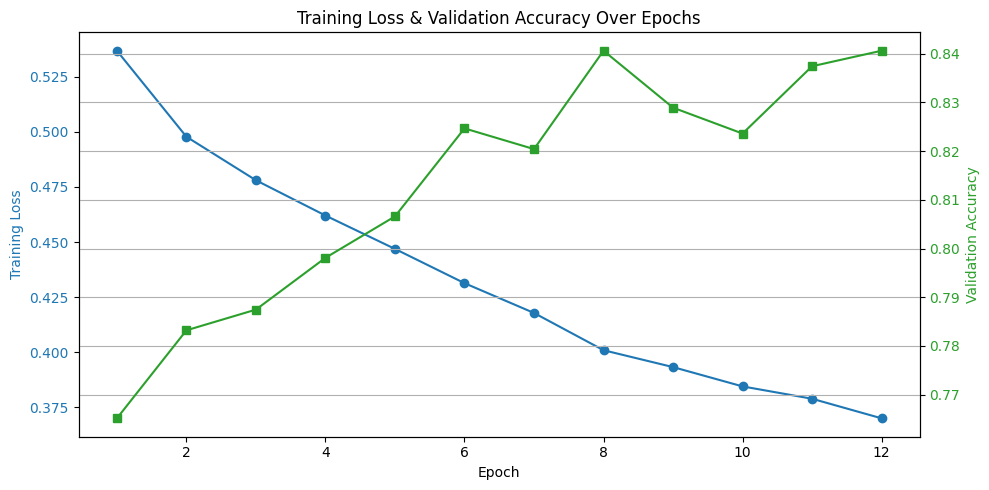

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
val_accuracies = []

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, fc_units),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(fc_units, 1)
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

print("\n🚀 Starting Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"🟦 Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"✅ Epoch {epoch+1} Completed — Avg Loss: {avg_loss:.4f}")

    # 🧪 Validation phase with enumerate
    model.eval()
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        with torch.no_grad():
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        if batch_idx % 5 == 0:
            print(f"🟩 Validation Batch {batch_idx}/{len(val_loader)}")

    val_acc = correct / total
    val_accuracies.append(val_acc)
    print(f"🎯 Validation Accuracy: {val_acc:.4f}")

# 📈 Plot Loss and Accuracy
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(range(1, num_epochs+1), train_losses, marker='o', color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Second y-axis for accuracy
color = 'tab:green'
ax2.set_ylabel('Validation Accuracy', color=color)
ax2.plot(range(1, num_epochs+1), val_accuracies, marker='s', color=color, label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Training Loss & Validation Accuracy Over Epochs")
fig.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
save_dir="/content/drive/MyDrive/violence_detection_resnet"
model_path = os.path.join(save_dir, "resnet34_weights.pth")
torch.save(model.state_dict(), model_path)

In [ ]:
torch.save({
    'epoch': 12,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': 0.2448,
}, "/content/drive/MyDrive/violence_detection_resnet/full_checkpoint.pth")



🔁 Resuming training from epoch 13...

🟦 Epoch [14] Batch 0/704 - Loss: 0.2236
🟦 Epoch [14] Batch 10/704 - Loss: 0.1829
🟦 Epoch [14] Batch 20/704 - Loss: 0.4272
🟦 Epoch [14] Batch 30/704 - Loss: 0.2355
🟦 Epoch [14] Batch 40/704 - Loss: 0.1061
🟦 Epoch [14] Batch 50/704 - Loss: 0.2731
🟦 Epoch [14] Batch 60/704 - Loss: 0.2591
🟦 Epoch [14] Batch 70/704 - Loss: 0.2403
🟦 Epoch [14] Batch 80/704 - Loss: 0.3716
🟦 Epoch [14] Batch 90/704 - Loss: 0.1973
🟦 Epoch [14] Batch 100/704 - Loss: 0.1914
🟦 Epoch [14] Batch 110/704 - Loss: 0.1517
🟦 Epoch [14] Batch 120/704 - Loss: 0.2171
🟦 Epoch [14] Batch 130/704 - Loss: 0.2193
🟦 Epoch [14] Batch 140/704 - Loss: 0.3142
🟦 Epoch [14] Batch 150/704 - Loss: 0.1074
🟦 Epoch [14] Batch 160/704 - Loss: 0.1744
🟦 Epoch [14] Batch 170/704 - Loss: 0.1142
🟦 Epoch [14] Batch 180/704 - Loss: 0.2620
🟦 Epoch [14] Batch 190/704 - Loss: 0.1232
🟦 Epoch [14] Batch 200/704 - Loss: 0.2479
🟦 Epoch [14] Batch 210/704 - Loss: 0.4064
🟦 Epoch [14] Batch 220/704 - Loss: 0.2907
🟦 Epoc

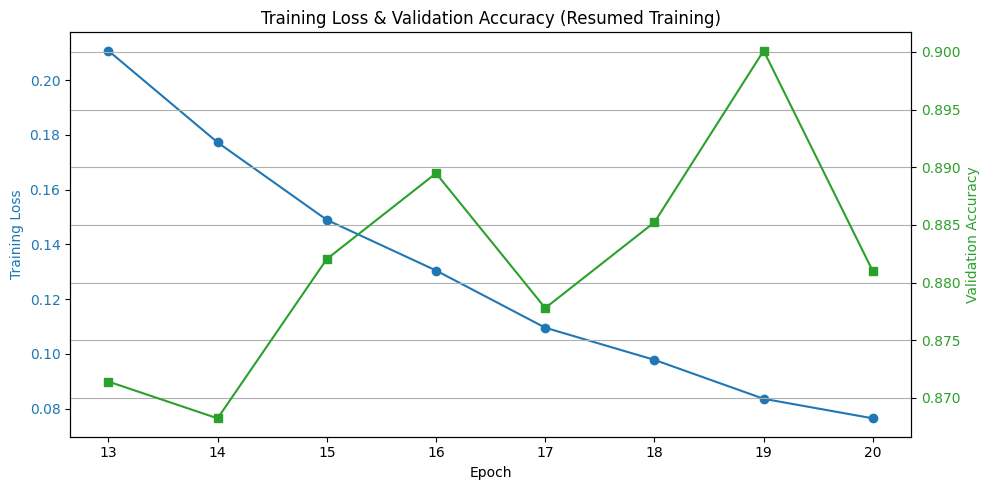

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn


train_losses = []
val_accuracies = []


model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, fc_units),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(fc_units, 1)
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

# === Load Checkpoint ===
checkpoint_path = "/content/drive/MyDrive/violence_detection_resnet/full_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

print(f"\n🔁 Resuming training from epoch {start_epoch}...\n")

# === Continue Training ===
for epoch in range(start_epoch, start_epoch + 8):  # continue for num_epochs more
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"🟦 Epoch [{epoch+1}] Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"✅ Epoch {epoch+1} Completed — Avg Loss: {avg_loss:.4f}")

    # === Validation ===
    model.eval()
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        with torch.no_grad():
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        if batch_idx % 5 == 0:
            print(f"🟩 Validation Batch {batch_idx}/{len(val_loader)}")

    val_acc = correct / total
    val_accuracies.append(val_acc)
    print(f"🎯 Validation Accuracy: {val_acc:.4f}")

# === 📈 Plot Loss and Accuracy ===
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Training Loss
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(range(start_epoch, start_epoch + len(train_losses)), train_losses, marker='o', color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Plot Validation Accuracy on secondary y-axis
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Validation Accuracy', color=color)
ax2.plot(range(start_epoch, start_epoch + len(val_accuracies)), val_accuracies, marker='s', color=color, label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Training Loss & Validation Accuracy (Resumed Training)")
fig.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
torch.save({
    'epoch': 20,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': 0.0765,
}, "/content/drive/MyDrive/violence_detection_resnet/full_checkpoint.pth")



🔁 Resuming training from epoch 21...

🟦 Epoch [21] Batch 0/704 - Loss: 0.0353
🟦 Epoch [21] Batch 10/704 - Loss: 0.0458
🟦 Epoch [21] Batch 20/704 - Loss: 0.0136
🟦 Epoch [21] Batch 30/704 - Loss: 0.0198
🟦 Epoch [21] Batch 40/704 - Loss: 0.0736
🟦 Epoch [21] Batch 50/704 - Loss: 0.0189
🟦 Epoch [21] Batch 60/704 - Loss: 0.0051
🟦 Epoch [21] Batch 70/704 - Loss: 0.0159
🟦 Epoch [21] Batch 80/704 - Loss: 0.0291
🟦 Epoch [21] Batch 90/704 - Loss: 0.0140
🟦 Epoch [21] Batch 100/704 - Loss: 0.0088
🟦 Epoch [21] Batch 110/704 - Loss: 0.0455
🟦 Epoch [21] Batch 120/704 - Loss: 0.0291
🟦 Epoch [21] Batch 130/704 - Loss: 0.0216
🟦 Epoch [21] Batch 140/704 - Loss: 0.0360
🟦 Epoch [21] Batch 150/704 - Loss: 0.0795
🟦 Epoch [21] Batch 160/704 - Loss: 0.0009
🟦 Epoch [21] Batch 170/704 - Loss: 0.0495
🟦 Epoch [21] Batch 180/704 - Loss: 0.1456
🟦 Epoch [21] Batch 190/704 - Loss: 0.1286
🟦 Epoch [21] Batch 200/704 - Loss: 0.0496
🟦 Epoch [21] Batch 210/704 - Loss: 0.3206
🟦 Epoch [21] Batch 220/704 - Loss: 0.0101
🟦 Epoc

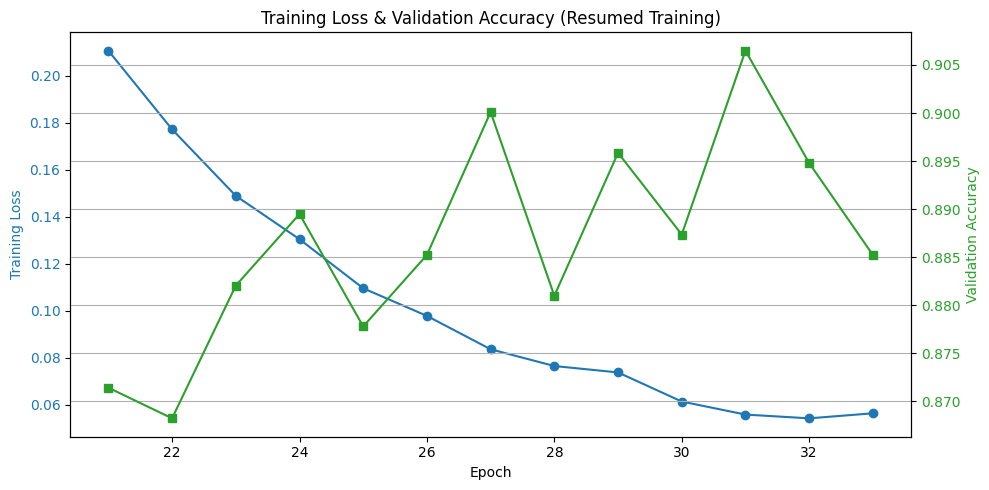

In [ ]:
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, fc_units),     # use same fc_units
    nn.ReLU(),
    nn.Dropout(dropout_rate),              # same dropout
    nn.Linear(fc_units, 1)
)
model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

# === Load Checkpoint ===
checkpoint_path = "/content/drive/MyDrive/violence_detection_resnet/full_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

print(f"\n🔁 Resuming training from epoch {start_epoch}...\n")

# === Continue Training ===
for epoch in range(start_epoch, start_epoch + 5):  # continue for num_epochs more
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"🟦 Epoch [{epoch}] Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"✅ Epoch {epoch} Completed — Avg Loss: {avg_loss:.4f}")

    # === Validation ===
    model.eval()
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        with torch.no_grad():
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        if batch_idx % 5 == 0:
            print(f"🟩 Validation Batch {batch_idx}/{len(val_loader)}")

    val_acc = correct / total
    val_accuracies.append(val_acc)
    print(f"🎯 Validation Accuracy: {val_acc:.4f}")

# === 📈 Plot Loss and Accuracy ===
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Training Loss
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(range(start_epoch, start_epoch + len(train_losses)), train_losses, marker='o', color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Plot Validation Accuracy on secondary y-axis
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Validation Accuracy', color=color)
ax2.plot(range(start_epoch, start_epoch + len(val_accuracies)), val_accuracies, marker='s', color=color, label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Training Loss & Validation Accuracy (Resumed Training)")
fig.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
torch.save({
    'epoch': 25,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': 0.0,
}, "/content/drive/MyDrive/violence_detection_resnet/full_checkpoint_final.pth")


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Re-initialize model architecture
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, fc_units),  # use same fc_units
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(fc_units, 1)
)

model.to(device)
model_path = "/content/drive/MyDrive/violence_detection_resnet/full_checkpoint_final.pth"
checkpoint = torch.load(model_path, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
correct = 0
total = 0
for batch_idx, (images, labels) in enumerate(val_loader):
    images = images.to(device)
    labels = labels.to(device).float().unsqueeze(1)
    with torch.no_grad():
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    if batch_idx % 5 == 0:
        print(f"🟩 Validation Batch {batch_idx}/{len(val_loader)}")

val_acc = correct / total

print(f"🎯 Validation Accuracy: {val_acc:.4f}")

🟩 Validation Batch 0/30
🟩 Validation Batch 5/30
🟩 Validation Batch 10/30
🟩 Validation Batch 15/30
🟩 Validation Batch 20/30
🟩 Validation Batch 25/30
🎯 Validation Accuracy: 0.8852


In [ ]:
correct = 0
total = 0
for batch_idx, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device).float().unsqueeze(1)
    with torch.no_grad():
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.4).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    if batch_idx % 5 == 0:
        print(f"🟩 testing Batch {batch_idx}/{len(test_loader)}")

val_acc = correct / total

print(f"🎯 testing Accuracy: {val_acc:.4f}")

🟩 testing Batch 0/30
🟩 testing Batch 5/30
🟩 testing Batch 10/30
🟩 testing Batch 15/30
🟩 testing Batch 20/30
🟩 testing Batch 25/30
🎯 testing Accuracy: 0.9126


In [ ]:
correct = 0
total = 0
for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device).float().unsqueeze(1)
    with torch.no_grad():
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.4).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    if batch_idx % 5 == 0:
        print(f"🟩 training Batch {batch_idx}/{len(train_loader)}")

val_acc = correct / total

print(f"🎯 training Accuracy: {val_acc:.4f}")

🟩 training Batch 0/704
🟩 training Batch 5/704
🟩 training Batch 10/704
🟩 training Batch 15/704
🟩 training Batch 20/704
🟩 training Batch 25/704
🟩 training Batch 30/704
🟩 training Batch 35/704
🟩 training Batch 40/704
🟩 training Batch 45/704
🟩 training Batch 50/704
🟩 training Batch 55/704
🟩 training Batch 60/704
🟩 training Batch 65/704
🟩 training Batch 70/704
🟩 training Batch 75/704
🟩 training Batch 80/704
🟩 training Batch 85/704
🟩 training Batch 90/704
🟩 training Batch 95/704
🟩 training Batch 100/704
🟩 training Batch 105/704
🟩 training Batch 110/704
🟩 training Batch 115/704
🟩 training Batch 120/704
🟩 training Batch 125/704
🟩 training Batch 130/704
🟩 training Batch 135/704
🟩 training Batch 140/704
🟩 training Batch 145/704
🟩 training Batch 150/704
🟩 training Batch 155/704
🟩 training Batch 160/704
🟩 training Batch 165/704
🟩 training Batch 170/704
🟩 training Batch 175/704
🟩 training Batch 180/704
🟩 training Batch 185/704
🟩 training Batch 190/704
🟩 training Batch 195/704
🟩 training Batch 200/7